![Logo](logoGalileo.png "Logo")
***      
# CIENCIA DE DATOS EN PYTHON SECCION *U*
## *PROYECTO DATAWAREHOUSE CON PYTHON Y AWS-RDS*
##### **Pedro Josué Chamale Perez** - __23000478__

In [80]:
import pandas as pd
import numpy as np
import random
import datetime
import boto3
import psycopg2
import configparser
import mysql.connector
import pyodbc

# 1. Creación de servicio AWS-RDS en MySQL, creación de tablas, carga de datos utilizando python y pandas

#### Iniciación de Variables

In [2]:
rdsIdentifier = 'db-23000478' #nombre de la instancia

#### Cargamos archivo de configuraciones

In [3]:
config = configparser.ConfigParser()
config.read('escec.cfg')

['escec.cfg']

### Creamos Instancia de RDS 

In [4]:
aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                    aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                    region_name='us-east-2')

#### Verificamos Instancias de RDS disponibles

In [5]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds ['db-23000478', 'dw-db-23000478']


#### Creación de Servicio RDS

In [6]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifier,
            DBInstanceClass="db.t3.micro",
            Engine="mysql",
            MasterUsername=config.get('RDS', 'DB_USER'),
            MasterUserPassword=config.get('RDS', 'DB_PASSWORD'),
            Port=int(config.get('RDS', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print(response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

La Instancia de Base de Datos ya Existe.


##### Recordemos Esperar unos minutos para consultar la informaicón de la instancia.

##### Obtenemos URL del Host

In [7]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifier)
     RDS_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_HOST)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

db-23000478.cd8uefq07bqg.us-east-2.rds.amazonaws.com


##### Conexión a Base de Datos MySQL con Python

In [8]:
import sql_queries

try:
    db_conn = mysql.connector.connect(
        user=config.get('RDS', 'DB_USER'),
        password=config.get('RDS', 'DB_PASSWORD'), 
        host= RDS_HOST
    )

    cursor = db_conn.cursor()
    cursor.execute(sql_queries.DDL_QUERY, multi=True)
    db_conn.commit()
    print("Base de Datos Creada Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Base de Datos Creada Exitosamente


##### Generación de funcion y driver para MySQL - Insertar Datos en la Tabla

In [9]:
def insertDataToSQL(data_dict, table_name):
     #postgres_driver = f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""    
     mysql_driver = f"""mysql+mysqlconnector://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""           
     df_data = pd.DataFrame.from_records(data_dict)
     try:
          response = df_data.to_sql(table_name, mysql_driver, index=False, if_exists='append')
          print('Se han insertado nuevos registros.')
     except Exception as ex:
          print(ex)

##### Insertar Datos en la Tabla Curso

In [13]:
data_sc_curso = [
     {'idCurso': 1, 'nombreDescriptivo': 'Primero'},
     {'idCurso': 2, 'nombreDescriptivo': 'Segundo'},
     {'idCurso': 3, 'nombreDescriptivo': 'Tercero'},
     {'idCurso': 4, 'nombreDescriptivo': 'Cuarto'},
     {'idCurso': 5, 'nombreDescriptivo': 'Master'},
     {'idCurso': 6, 'nombreDescriptivo': 'Doctorado'},
     ]

#insertamos data en tabla de categories
insertDataToSQL(data_sc_curso, 'curso')

Se han insertado -1 nuevos registros.


#### Insertar Datos en la tabla alumnos

In [22]:
#Se cargan los datos de la tabla alumno de un archivo de texto alumnos.txt
data_sc_alumno = pd.read_csv('alumnos.txt',sep=";")

insertDataToSQL(data_sc_alumno, 'alumno')

Se han insertado nuevos registros.


#### Insertar Datos en la tabla profesor

In [34]:
data_sc_profesor = pd.read_csv('profe.txt',sep=";")

insertDataToSQL(data_sc_profesor, 'profesor')

Se han insertado nuevos registros.


##### Insertar Datos en la tabla telProf

In [38]:
data_sc_telProf = pd.read_csv('telProf.txt',sep=";") 

insertDataToSQL(data_sc_telProf, 'telProf')

Se han insertado nuevos registros.


C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:1666: UserWarning: The provided table name 'telProf' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


##### Insertamos Data en la tabla Asignatura

In [43]:
data_sc_asignatura = pd.read_csv("asignatura.txt",sep=";")

insertDataToSQL(data_sc_asignatura, 'asignatura')

(mysql.connector.errors.IntegrityError) 1062 (23000): Duplicate entry 'AS001' for key 'asignatura.PRIMARY'
[SQL: INSERT INTO asignatura (curso, `idAsignatura`, nombre, cuatrimestre, creditos, caracter, coordinador) VALUES (%(curso)s, %(idAsignatura)s, %(nombre)s, %(cuatrimestre)s, %(creditos)s, %(caracter)s, %(coordinador)s)]
[parameters: ({'curso': 1, 'idAsignatura': 'AS001', 'nombre': 'Algebra lineal', 'cuatrimestre': 2.0, 'creditos': 6.0, 'caracter': 'obligatoria', 'coordinador': 'PR001'}, {'curso': 1, 'idAsignatura': 'AS002', 'nombre': 'Análisis exploratorio de datos', 'cuatrimestre': 1.0, 'creditos': 6.0, 'caracter': 'obligatoria', 'coordinador': 'PR002'}, {'curso': 1, 'idAsignatura': 'AS003', 'nombre': 'Análisis matemático', 'cuatrimestre': 1.0, 'creditos': 6.0, 'caracter': 'obligatoria', 'coordinador': 'PR003'}, {'curso': 1, 'idAsignatura': 'AS004', 'nombre': 'Fundamentos de computadores y sistemas operativos', 'cuatrimestre': 2.0, 'creditos': 6.0, 'caracter': 'obligatoria', 'co

##### Insertar Data en la tabla impartir

In [46]:
data_sc_impartir = pd.read_csv("impartir.txt",sep="\t")

insertDataToSQL(data_sc_impartir, 'impartir')

Se han insertado nuevos registros.


##### Insertar Data en la tabla Matricula

In [48]:
data_sc_matricula = pd.read_csv("matricula.txt",sep=";")
data_sc_matricula
insertDataToSQL(data_sc_matricula, 'matricula')

Se han insertado nuevos registros.


# 2. Creación de tablas de Dimensiones y tabla de Hechos, creación de segunda instancia AWS-RDS en SQLServer

In [11]:
#Se establece la conexion con la instancia en AWS-RDS creada con MYSQL
mysql_driver = f"""mysql+mysqlconnector://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}""" 

### Creando dimension Profesores

In [12]:
sql_query = 'SELECT * FROM profesor;'
df_profesor = pd.read_sql(sql_query, mysql_driver)
df_profesor.head()

,idProfesor,NIF,nombre,apellido1,apellido2,email,direccion,codigoPostal,municipio,provincia,categoria
0,PR001,34417139B,Juan,Infante,Fraidias,juan.infante.fraidias@ucm.com,"Calle de los Almendros , 86",28070.0,Las Rozas,Madrid,Asociados
1,PR002,52479077P,David,Serna,Balmori,david.serna.balmori@ucm.com,"Calle Abarejo , 44",28017.0,Brea de Tajo,Madrid,Titulares Universidad
2,PR003,84277383X,Josefa,Pedraza,Travez,josefa.pedraza.travez@ucm.com,"Calle Abogados de Atocha , 145",28035.0,El Molar,Madrid,Contratados Doctores
3,PR004,72702217A,Jose Antonio,Belda,Leno,jose.antonio.belda.leno@ucm.com,"Calle de Ayamonte , 186",28080.0,Pezuela de las Torres,Madrid,Titulares Universidad
4,PR005,75239553F,Jose Luis,Barragan,Usategui,jose.luis.barragan.usategui@ucm.com,"Travesia del Almendro , 97",28038.0,Robledillo de la Jara,Madrid,Catedráticos de Escuela Universitaria


In [13]:
sql_query = 'SELECT * FROM telProf;'
df_telProf = pd.read_sql(sql_query, mysql_driver)
df_telProf.head()

,idProfesor,telefono
0,PR001,671701361.0
1,PR001,919821212.0
2,PR002,627009710.0
3,PR002,912086321.0
4,PR003,623534916.0


In [14]:
df_dim_profesor = df_profesor.merge(df_telProf, on='idProfesor', how='inner')

df_dim_profesor['nombre_profesor']= (df_dim_profesor['nombre']+' '
                                     +df_dim_profesor['apellido1']+' '
                                     +df_dim_profesor['apellido2'])

df_dim_profesor.drop(['nombre', 'apellido1', 'apellido2'], axis=1,  inplace=True)

df_dim_profesor.head()

,idProfesor,NIF,email,direccion,codigoPostal,municipio,provincia,categoria,telefono,nombre_profesor
0,PR001,34417139B,juan.infante.fraidias@ucm.com,"Calle de los Almendros , 86",28070.0,Las Rozas,Madrid,Asociados,671701361.0,Juan Infante Fraidias
1,PR001,34417139B,juan.infante.fraidias@ucm.com,"Calle de los Almendros , 86",28070.0,Las Rozas,Madrid,Asociados,919821212.0,Juan Infante Fraidias
2,PR002,52479077P,david.serna.balmori@ucm.com,"Calle Abarejo , 44",28017.0,Brea de Tajo,Madrid,Titulares Universidad,627009710.0,David Serna Balmori
3,PR002,52479077P,david.serna.balmori@ucm.com,"Calle Abarejo , 44",28017.0,Brea de Tajo,Madrid,Titulares Universidad,912086321.0,David Serna Balmori
4,PR003,84277383X,josefa.pedraza.travez@ucm.com,"Calle Abogados de Atocha , 145",28035.0,El Molar,Madrid,Contratados Doctores,623534916.0,Josefa Pedraza Travez


### Creando dimension Alumnos

In [15]:
sql_query = 'SELECT * FROM alumno;'
df_alumno = pd.read_sql(sql_query, mysql_driver)
df_alumno.head()

,idAlumno,NIF,nombre,apellido1,apellido2,email,direccion,codigoPostal,municipio,provincia,beca
0,AL001,12345678A,Antonio,Garcia,Cano,antonio.garcia.cano@ucm.com,"Calle de La Acebeda , 106",28025.0,Batres,Madrid,no
1,AL002,12345679B,Jose,Gonzalez,Guerrero,jose.gonzalez.guerrero@ucm.com,"Camino de La Aceña , 340",28040.0,San Martín de Valdeiglesias,Madrid,no
2,AL003,12345680C,Maria Carmen,Rodriguez,Lozano,maria.carmen.rodriguez.lozano@ucm.com,"Calle de La Adrada , 342",28048.0,Horcajo de la Sierra-Aoslos,Madrid,no
3,AL004,12345681D,Maria,Fernandez,Cortes,maria.fernandez.cortes@ucm.com,"Paraje La Aldehuela , 242",28043.0,Cenicientos,Madrid,si
4,AL005,12345682E,Manuel,Lopez,Castillo,manuel.lopez.castillo@ucm.com,"Paraje La Aldehuela , 154",28022.0,Manzanares el Real,Madrid,no


In [16]:
sql_query = 'SELECT * FROM matricula;'
df_matricula = pd.read_sql(sql_query, mysql_driver)
df_matricula.head()

,idAlumno,idAsignatura,nota
0,AL003,AS001,6.99
1,AL003,AS002,9.71
2,AL003,AS003,10.00
3,AL003,AS004,8.89
4,AL003,AS005,8.49


In [17]:
sql_query = 'SELECT * FROM asignatura;'
df_asignatura = pd.read_sql(sql_query, mysql_driver)
df_asignatura.head()

,curso,idAsignatura,nombre,cuatrimestre,creditos,caracter,coordinador
0,1.0,AS001,Algebra lineal,2,6.0,obligatoria,PR001
1,1.0,AS002,Análisis exploratorio de datos,1,6.0,obligatoria,PR002
2,1.0,AS003,Análisis matemático,1,6.0,obligatoria,PR003
3,1.0,AS004,Fundamentos de computadores y sistemas operativos,2,6.0,obligatoria,PR004
4,1.0,AS005,Fundamentos de organización de empresas,1,6.0,obligatoria,PR005


In [18]:
df_alumno_matricula = df_alumno.merge(df_matricula, on='idAlumno', how='inner')
df_alumno_matricula['nombre_alumno']= (df_alumno_matricula['nombre'] +' '
                                        + df_alumno_matricula['apellido1'] +' '
                                        + df_alumno_matricula['apellido2'])
df_alumno_matricula.head()

,idAlumno,NIF,nombre,apellido1,apellido2,email,direccion,codigoPostal,municipio,provincia,beca,idAsignatura,nota,nombre_alumno
0,AL001,12345678A,Antonio,Garcia,Cano,antonio.garcia.cano@ucm.com,"Calle de La Acebeda , 106",28025.0,Batres,Madrid,no,AS084,2.54,Antonio Garcia Cano
1,AL001,12345678A,Antonio,Garcia,Cano,antonio.garcia.cano@ucm.com,"Calle de La Acebeda , 106",28025.0,Batres,Madrid,no,AS085,7.37,Antonio Garcia Cano
2,AL001,12345678A,Antonio,Garcia,Cano,antonio.garcia.cano@ucm.com,"Calle de La Acebeda , 106",28025.0,Batres,Madrid,no,AS086,10.00,Antonio Garcia Cano
3,AL001,12345678A,Antonio,Garcia,Cano,antonio.garcia.cano@ucm.com,"Calle de La Acebeda , 106",28025.0,Batres,Madrid,no,AS087,4.96,Antonio Garcia Cano
4,AL001,12345678A,Antonio,Garcia,Cano,antonio.garcia.cano@ucm.com,"Calle de La Acebeda , 106",28025.0,Batres,Madrid,no,AS088,5.96,Antonio Garcia Cano


In [19]:
df_dim_alumno = df_alumno_matricula.merge(df_asignatura, on='idAsignatura', how='inner', suffixes=('', '_curso'))
df_dim_alumno.head()

,idAlumno,NIF,nombre,apellido1,apellido2,email,direccion,codigoPostal,municipio,provincia,beca,idAsignatura,nota,nombre_alumno,curso,nombre_curso,cuatrimestre,creditos,caracter,coordinador
0,AL001,12345678A,Antonio,Garcia,Cano,antonio.garcia.cano@ucm.com,"Calle de La Acebeda , 106",28025.0,Batres,Madrid,no,AS084,2.54,Antonio Garcia Cano,5.0,Fundamentos de tratamiento de datos para Data ...,1,6.0,obligatoria,PR002
1,AL006,12345683F,Francisco,Martinez,Santos,francisco.martinez.santos@ucm.com,"Paraje La Aldehuela , 34",28021.0,Cobeña,Madrid,no,AS084,10.00,Francisco Martinez Santos,5.0,Fundamentos de tratamiento de datos para Data ...,1,6.0,obligatoria,PR002
2,AL015,12345692O,Jesus,Moreno,Castro,jesus.moreno.castro@ucm.com,"Vereda de La Calderona , 423",28020.0,Pelayos de la Presa,Madrid,no,AS084,2.09,Jesus Moreno Castro,5.0,Fundamentos de tratamiento de datos para Data ...,1,6.0,obligatoria,PR002
3,AL023,12345700W,Maria Teresa,Dominguez,Ramirez,maria.teresa.dominguez.ramirez@ucm.com,"Plaza de La Carolina , 358",28006.0,Valdemorillo,Madrid,no,AS084,3.56,Maria Teresa Dominguez Ramirez,5.0,Fundamentos de tratamiento de datos para Data ...,1,6.0,obligatoria,PR002
4,AL024,12345701X,Ana,Vazquez,Gil,ana.vazquez.gil@ucm.com,"Calle de La Ceiba , 356",28031.0,Cadalso de los Vidrios,Madrid,si,AS084,6.81,Ana Vazquez Gil,5.0,Fundamentos de tratamiento de datos para Data ...,1,6.0,obligatoria,PR002


In [20]:
df_dim_alumno.drop(['idAsignatura', 'curso', 'cuatrimestre', 'creditos','caracter',
                    'coordinador','nombre','apellido1','apellido2'],
                   axis=1,  inplace=True)

df_dim_alumno.head()

,idAlumno,NIF,email,direccion,codigoPostal,municipio,provincia,beca,nota,nombre_alumno,nombre_curso
0,AL001,12345678A,antonio.garcia.cano@ucm.com,"Calle de La Acebeda , 106",28025.0,Batres,Madrid,no,2.54,Antonio Garcia Cano,Fundamentos de tratamiento de datos para Data ...
1,AL006,12345683F,francisco.martinez.santos@ucm.com,"Paraje La Aldehuela , 34",28021.0,Cobeña,Madrid,no,10.00,Francisco Martinez Santos,Fundamentos de tratamiento de datos para Data ...
2,AL015,12345692O,jesus.moreno.castro@ucm.com,"Vereda de La Calderona , 423",28020.0,Pelayos de la Presa,Madrid,no,2.09,Jesus Moreno Castro,Fundamentos de tratamiento de datos para Data ...
3,AL023,12345700W,maria.teresa.dominguez.ramirez@ucm.com,"Plaza de La Carolina , 358",28006.0,Valdemorillo,Madrid,no,3.56,Maria Teresa Dominguez Ramirez,Fundamentos de tratamiento de datos para Data ...
4,AL024,12345701X,ana.vazquez.gil@ucm.com,"Calle de La Ceiba , 356",28031.0,Cadalso de los Vidrios,Madrid,si,6.81,Ana Vazquez Gil,Fundamentos de tratamiento de datos para Data ...


### Creando Dimension Curso

In [21]:
sql_query = 'SELECT * FROM asignatura;'
df_asig = pd.read_sql(sql_query, mysql_driver)
df_asig.head()

,curso,idAsignatura,nombre,cuatrimestre,creditos,caracter,coordinador
0,1.0,AS001,Algebra lineal,2,6.0,obligatoria,PR001
1,1.0,AS002,Análisis exploratorio de datos,1,6.0,obligatoria,PR002
2,1.0,AS003,Análisis matemático,1,6.0,obligatoria,PR003
3,1.0,AS004,Fundamentos de computadores y sistemas operativos,2,6.0,obligatoria,PR004
4,1.0,AS005,Fundamentos de organización de empresas,1,6.0,obligatoria,PR005


In [22]:
sql_query = 'SELECT * FROM profesor;'
df_prof = pd.read_sql(sql_query, mysql_driver)

df_prof['nombre_profesor']= (df_prof['nombre']+' '
                                     +df_prof['apellido1']+' '
                                     +df_prof['apellido2'])

df_prof.drop(['nombre', 'apellido1', 'apellido2','NIF','email',
                      'direccion','codigoPostal','municipio','provincia','categoria'], axis=1,  inplace=True)

df_prof.head()

,idProfesor,nombre_profesor
0,PR001,Juan Infante Fraidias
1,PR002,David Serna Balmori
2,PR003,Josefa Pedraza Travez
3,PR004,Jose Antonio Belda Leno
4,PR005,Jose Luis Barragan Usategui


In [23]:
sql_query = 'SELECT * FROM curso;'
df_curso = pd.read_sql(sql_query, mysql_driver)
df_curso.head()

,idCurso,nombreDescriptivo,nAsignaturas
0,1.0,Primero,0.0
1,2.0,Segundo,0.0
2,3.0,Tercero,0.0
3,4.0,Cuarto,0.0
4,5.0,Master,0.0


In [24]:
df_dim_curso = df_asig.merge(df_prof, left_on='coordinador', right_on='idProfesor', how='inner')
df_dim_curso = df_dim_curso.merge(df_curso, left_on='curso', right_on='idCurso', how='inner')
df_dim_curso

,curso,idAsignatura,nombre,cuatrimestre,creditos,caracter,coordinador,idProfesor,nombre_profesor,idCurso,nombreDescriptivo,nAsignaturas
0,1.0,AS001,Algebra lineal,2,6.0,obligatoria,PR001,PR001,Juan Infante Fraidias,1.0,Primero,0.0
1,1.0,AS002,Análisis exploratorio de datos,1,6.0,obligatoria,PR002,PR002,David Serna Balmori,1.0,Primero,0.0
2,1.0,AS010,Proyecto I. Comprensión de datos,2,6.0,obligatoria,PR002,PR002,David Serna Balmori,1.0,Primero,0.0
3,1.0,AS003,Análisis matemático,1,6.0,obligatoria,PR003,PR003,Josefa Pedraza Travez,1.0,Primero,0.0
4,1.0,AS007,Matemáticas discretas,1,6.0,obligatoria,PR003,PR003,Josefa Pedraza Travez,1.0,Primero,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.0,AS096,Gestión y explotación de almacenes de datos,1,0.0,optativa,PR002,PR002,David Serna Balmori,6.0,Doctorado,0.0
96,6.0,AS098,Gestión de relaciones con el cliente CRM,2,0.0,optativa,PR005,PR005,Jose Luis Barragan Usategui,6.0,Doctorado,0.0
97,6.0,AS099,Inteligencia de negocio y cuadro de mando inte...,2,0.0,optativa,PR005,PR005,Jose Luis Barragan Usategui,6.0,Doctorado,0.0
98,6.0,AS100,Modelos de decisión en marketing,2,0.0,optativa,PR005,PR005,Jose Luis Barragan Usategui,6.0,Doctorado,0.0


In [25]:
df_dim_curso.drop(['coordinador','idProfesor','curso','idCurso','nAsignaturas'], axis=1,  inplace=True)
df_dim_curso.head()

,idAsignatura,nombre,cuatrimestre,creditos,caracter,nombre_profesor,nombreDescriptivo
0,AS001,Algebra lineal,2,6.0,obligatoria,Juan Infante Fraidias,Primero
1,AS002,Análisis exploratorio de datos,1,6.0,obligatoria,David Serna Balmori,Primero
2,AS010,Proyecto I. Comprensión de datos,2,6.0,obligatoria,David Serna Balmori,Primero
3,AS003,Análisis matemático,1,6.0,obligatoria,Josefa Pedraza Travez,Primero
4,AS007,Matemáticas discretas,1,6.0,obligatoria,Josefa Pedraza Travez,Primero


### Creando Tabla de Hechos

In [26]:
sql_query = 'SELECT * FROM matricula;'
df_mat = pd.read_sql(sql_query, mysql_driver)

df_mat.head()

,idAlumno,idAsignatura,nota
0,AL003,AS001,6.99
1,AL003,AS002,9.71
2,AL003,AS003,10.00
3,AL003,AS004,8.89
4,AL003,AS005,8.49


In [27]:
df_matricula_asignatura = df_mat.merge(df_asig, on='idAsignatura', how='inner')
df_matricula_asignatura

,idAlumno,idAsignatura,nota,curso,nombre,cuatrimestre,creditos,caracter,coordinador
0,AL003,AS001,6.99,1.0,Algebra lineal,2,6.0,obligatoria,PR001
1,AL017,AS001,2.97,1.0,Algebra lineal,2,6.0,obligatoria,PR001
2,AL019,AS001,2.93,1.0,Algebra lineal,2,6.0,obligatoria,PR001
3,AL045,AS001,5.84,1.0,Algebra lineal,2,6.0,obligatoria,PR001
4,AL052,AS001,3.56,1.0,Algebra lineal,2,6.0,obligatoria,PR001
...,...,...,...,...,...,...,...,...,...
1724,AL125,AS095,10.00,6.0,Técnicas y metodología de la minería de datos ...,1,0.0,optativa,PR002
1725,AL173,AS095,6.71,6.0,Técnicas y metodología de la minería de datos ...,1,0.0,optativa,PR002
1726,AL174,AS095,10.00,6.0,Técnicas y metodología de la minería de datos ...,1,0.0,optativa,PR002
1727,AL181,AS095,3.01,6.0,Técnicas y metodología de la minería de datos ...,1,0.0,optativa,PR002


In [28]:
df_curso_ma = df_matricula_asignatura.merge(df_curso, left_on='curso',right_on='idCurso', how='inner')
df_curso_ma

,idAlumno,idAsignatura,nota,curso,nombre,cuatrimestre,creditos,caracter,coordinador,idCurso,nombreDescriptivo,nAsignaturas
0,AL003,AS001,6.99,1.0,Algebra lineal,2,6.0,obligatoria,PR001,1.0,Primero,0.0
1,AL017,AS001,2.97,1.0,Algebra lineal,2,6.0,obligatoria,PR001,1.0,Primero,0.0
2,AL019,AS001,2.93,1.0,Algebra lineal,2,6.0,obligatoria,PR001,1.0,Primero,0.0
3,AL045,AS001,5.84,1.0,Algebra lineal,2,6.0,obligatoria,PR001,1.0,Primero,0.0
4,AL052,AS001,3.56,1.0,Algebra lineal,2,6.0,obligatoria,PR001,1.0,Primero,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1724,AL125,AS095,10.00,6.0,Técnicas y metodología de la minería de datos ...,1,0.0,optativa,PR002,6.0,Doctorado,0.0
1725,AL173,AS095,6.71,6.0,Técnicas y metodología de la minería de datos ...,1,0.0,optativa,PR002,6.0,Doctorado,0.0
1726,AL174,AS095,10.00,6.0,Técnicas y metodología de la minería de datos ...,1,0.0,optativa,PR002,6.0,Doctorado,0.0
1727,AL181,AS095,3.01,6.0,Técnicas y metodología de la minería de datos ...,1,0.0,optativa,PR002,6.0,Doctorado,0.0


In [29]:
df_profesor_cma = df_curso_ma.merge(df_prof, left_on='coordinador',right_on='idProfesor', how='inner')
df_profesor_cma.head()

,idAlumno,idAsignatura,nota,curso,nombre,cuatrimestre,creditos,caracter,coordinador,idCurso,nombreDescriptivo,nAsignaturas,idProfesor,nombre_profesor
0,AL003,AS001,6.99,1.0,Algebra lineal,2,6.0,obligatoria,PR001,1.0,Primero,0.0,PR001,Juan Infante Fraidias
1,AL017,AS001,2.97,1.0,Algebra lineal,2,6.0,obligatoria,PR001,1.0,Primero,0.0,PR001,Juan Infante Fraidias
2,AL019,AS001,2.93,1.0,Algebra lineal,2,6.0,obligatoria,PR001,1.0,Primero,0.0,PR001,Juan Infante Fraidias
3,AL045,AS001,5.84,1.0,Algebra lineal,2,6.0,obligatoria,PR001,1.0,Primero,0.0,PR001,Juan Infante Fraidias
4,AL052,AS001,3.56,1.0,Algebra lineal,2,6.0,obligatoria,PR001,1.0,Primero,0.0,PR001,Juan Infante Fraidias


In [30]:
df_profesor_cma.drop(['curso','nombre','cuatrimestre','creditos','caracter','coordinador',
                     'nombreDescriptivo','nAsignaturas','nombre_profesor'], axis=1,  inplace=True)
df_profesor_cma

,idAlumno,idAsignatura,nota,idCurso,idProfesor
0,AL003,AS001,6.99,1.0,PR001
1,AL017,AS001,2.97,1.0,PR001
2,AL019,AS001,2.93,1.0,PR001
3,AL045,AS001,5.84,1.0,PR001
4,AL052,AS001,3.56,1.0,PR001
...,...,...,...,...,...
1724,AL053,AS097,6.77,6.0,PR037
1725,AL056,AS097,5.94,6.0,PR037
1726,AL066,AS097,7.91,6.0,PR037
1727,AL111,AS097,10.00,6.0,PR037


### Creación de AWS-RDS en SQL Server

In [31]:
rdsIdentifierSQLServer = 'dw-db-23000478' #nombre de la instancia

In [32]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds ['db-23000478', 'dw-db-23000478']


In [33]:
try:
    response_sql = aws_conn.create_db_instance(
            AllocatedStorage=20,
            DBInstanceIdentifier=rdsIdentifierSQLServer,
            DBInstanceClass="db.t2.micro",
            Engine="sqlserver-ex",
            EngineVersion="14.00.3451.2.v1",
            MasterUsername=config.get('RDS_SQLSERVER', 'DB_USER'),
            MasterUserPassword=config.get('RDS_SQLSERVER', 'DB_PASSWORD'),
            Port=int(config.get('RDS_SQLSERVER', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print(response_sql)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

La Instancia de Base de Datos ya Existe.


In [34]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifierSQLServer)
     RDS_HOST_SQLServer = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_HOST_SQLServer)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

dw-db-23000478.cd8uefq07bqg.us-east-2.rds.amazonaws.com


In [35]:
import dw_23000478

direccion_servidor = RDS_HOST_SQLServer
nombre_bd = config.get('RDS_SQLSERVER','DB_NAME')
nombre_usuario = config.get('RDS_SQLSERVER','DB_USER')
password = config.get('RDS_SQLSERVER','DB_PASSWORD')

try:
    conexion = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' +
                              direccion_servidor+';DATABASE='+nombre_bd+';UID='+nombre_usuario+';PWD=' + password)
    
    mycursorsql = conexion.cursor()
    mycursorsql.execute(dw_23000478.DW_DDL_QUERY)
    conexion.commit()
    print("Data Warehouse Creado Exitosamente")
    
except Exception as e:
    # Atrapar error
    print("Ocurrió un error al conectar a SQL Server: ", e)

Data Warehouse Creado Exitosamente


In [36]:
#Se realiza la conexión con la base de datos de SQL SERVER
sqlserver_driver = f"""mssql+pyodbc://{config.get('RDS_SQLSERVER', 'DB_USER')}:{config.get('RDS_SQLSERVER', 'DB_PASSWORD')}@{RDS_HOST_SQLServer}:{config.get('RDS_SQLSERVER', 'DB_PORT')}/{config.get('RDS_SQLSERVER', 'DB_NAME')}?driver=ODBC+Driver+17+for+SQL+Server"""

In [37]:
df_profesor_cma.head()

,idAlumno,idAsignatura,nota,idCurso,idProfesor
0,AL003,AS001,6.99,1.0,PR001
1,AL017,AS001,2.97,1.0,PR001
2,AL019,AS001,2.93,1.0,PR001
3,AL045,AS001,5.84,1.0,PR001
4,AL052,AS001,3.56,1.0,PR001


### Insertando Dataframe a Tablas de DW en SQLServer

In [37]:
#Insertando dimension de Profesor
df_dim_profesor.to_sql('dim_profesor', sqlserver_driver, index=False, if_exists='append')

-1

In [38]:
#Insertando dimension de Alumno
df_dim_alumno.to_sql('dim_alumno', sqlserver_driver, index=False, if_exists='append')

-1

In [40]:
#Insertando dimension de Curso
df_dim_curso.to_sql('dim_curso', sqlserver_driver, index=False, if_exists='append')

-1

In [42]:
#Insertando Tabla de Hechos
df_profesor_cma.to_sql('fact_table', sqlserver_driver, index=False, if_exists='append')

-1

### Consultando la información cargada en SQLServer

In [81]:
sql_query_server = 'SELECT * FROM [dw-23000478].[dbo].[dim_profesor];'
pd.read_sql(sql_query_server,sqlserver_driver)

,id,idProfesor,NIF,email,direccion,codigoPostal,municipio,provincia,categoria,telefono,nombre_profesor
0,1,PR001,34417139B,juan.infante.fraidias@ucm.com,"Calle de los Almendros , 86",28070.0,Las Rozas,Madrid,Asociados,671701361.0,Juan Infante Fraidias
1,2,PR001,34417139B,juan.infante.fraidias@ucm.com,"Calle de los Almendros , 86",28070.0,Las Rozas,Madrid,Asociados,919821212.0,Juan Infante Fraidias
2,3,PR002,52479077P,david.serna.balmori@ucm.com,"Calle Abarejo , 44",28017.0,Brea de Tajo,Madrid,Titulares Universidad,627009710.0,David Serna Balmori
3,4,PR002,52479077P,david.serna.balmori@ucm.com,"Calle Abarejo , 44",28017.0,Brea de Tajo,Madrid,Titulares Universidad,912086321.0,David Serna Balmori
4,5,PR003,84277383X,josefa.pedraza.travez@ucm.com,"Calle Abogados de Atocha , 145",28035.0,El Molar,Madrid,Contratados Doctores,623534916.0,Josefa Pedraza Travez
...,...,...,...,...,...,...,...,...,...,...,...
91,92,PR046,47970524A,ana.padron.balada@ucm.com,"Calle de Argentona , 179",28002.0,Boadilla del Monte,Madrid,Titulares Universidad,915318727.0,Ana Padron Balada
92,93,PR047,76965754O,rafael.figueroa.casal@ucm.com,"Calle de la Aeronave , 37",28004.0,Colmenarejo,Madrid,PDI predoctoral,666723740.0,Rafael Figueroa Casal
93,94,PR047,76965754O,rafael.figueroa.casal@ucm.com,"Calle de la Aeronave , 37",28004.0,Colmenarejo,Madrid,PDI predoctoral,915492151.0,Rafael Figueroa Casal
94,95,PR048,48034341Q,jose.manuel.nevado.veras@ucm.com,"Calle Arlanza , 170",28001.0,Ajalvir,Madrid,Catedráticos de Universidad,630209703.0,Jose Manuel Nevado Veras


# 3.Creación de graficas utilizando la informacion del DW


### ¿Cual es la cantidad de Catedraticos por categoria?

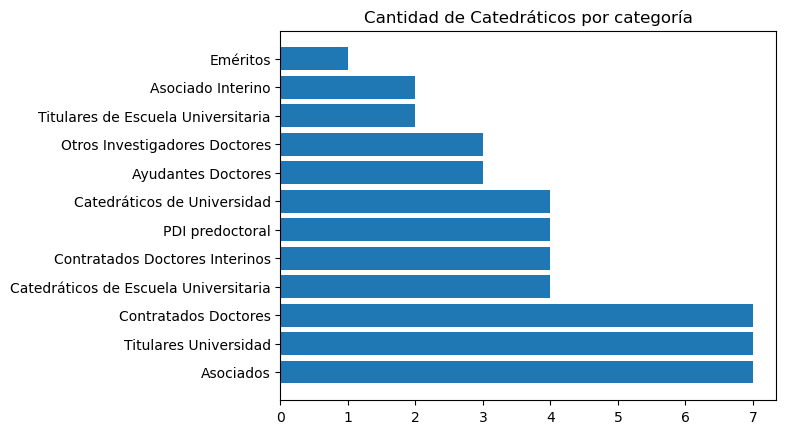

In [47]:
import matplotlib.pyplot as plt

x_1= df_profesor['categoria'].unique()
y_1= df_profesor['categoria'].value_counts().tolist()

plt.barh(x_1, y_1)
plt.title('Cantidad de Catedráticos por categoría')
plt.show()

### ¿Cual es la proporción de cursos segun el carácter?

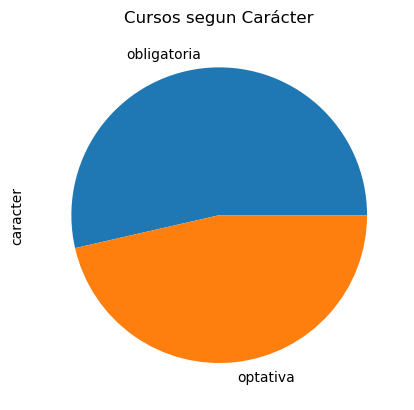

In [62]:
df_grafica_2['caracter'].value_counts().plot.pie()
plt.title("Cursos segun Carácter")
plt.show()

### ¿Como se ve la distribución de notas de los alumnos, tomando en comparación notas minimas, maximas y la media?

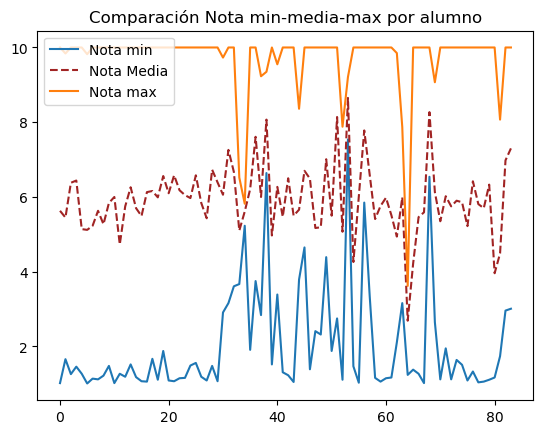

In [79]:
plt.plot(df_grafica_2['Nota min'])
plt.plot(df_grafica_2['Nota Media'],color='#a12424', linestyle='--')
plt.plot(df_grafica_2['Nota max'])
plt.legend(['Nota min', 'Nota Media', 'Nota max'], loc=2)
plt.title('Comparación Nota min-media-max por alumno')
plt.show()